# Design and Implementation of a Machine Learning-based Intrusion Detection System using KNN, SVM and Random Forest to Classify Network Traffic as Normal or Abnormal  

## Imports & Configs

In [1]:
# %pip install numpy pandas seaborn matplotlib scikit-learn optuna tabulate

In [1]:
import itertools
import joblib
import os
import warnings

# Data Analysis
import numpy as np
import pandas as pd

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
from tabulate import tabulate
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE

# ML Models
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

# Parameter-tunning (optimization)
import optuna

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

/Users/Air/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Data Preprocessing & EDA

In [2]:
train=pd.read_csv('Datasets/Train_data.csv')
test=pd.read_csv('Datasets/Test_data.csv')

In [23]:
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,tcp,exec,RSTO,0,0,0,0,0,0,...,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25188,0,tcp,ftp_data,SF,334,0,0,0,0,0,...,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,anomaly
25189,0,tcp,private,REJ,0,0,0,0,0,0,...,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25190,0,tcp,nnsp,S0,0,0,0,0,0,0,...,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [24]:
print(f"Training set Shape: {train.shape}")
print(f"Testing set Shape: {test.shape}")

Training set Shape: (25192, 42)
Testing set Shape: (22544, 41)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [6]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [7]:
# Numerical data summary
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Categorical data summary
train.describe(include='object')

,protocol_type,service,flag,class
count,25192,25192,25192,25192
unique,3,66,11,2
top,tcp,http,SF,normal
freq,20526,8003,14973,13449


## Missing Data

In [9]:
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")
else:
    print("No missing values")

No missing values


## Duplicates 

In [10]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


Great! No duplicates

## Outliers 

In [11]:
# def show_outliers(df):
#     for col in df.columns:
#         if col != 'class' and is_numeric_dtype(df[col]) and df[col].nunique() > 10:
#             fig, ax = plt.subplots(2, 1, figsize=(12, 8))
#             g1 = sns.boxplot(x = df[col], ax=ax[0])
#             g2 = sns.scatterplot(data=df, x=df[col],y=df['class'], ax=ax[1])
#             plt.show()

# show_outliers(train)

No outliers

<AxesSubplot:>

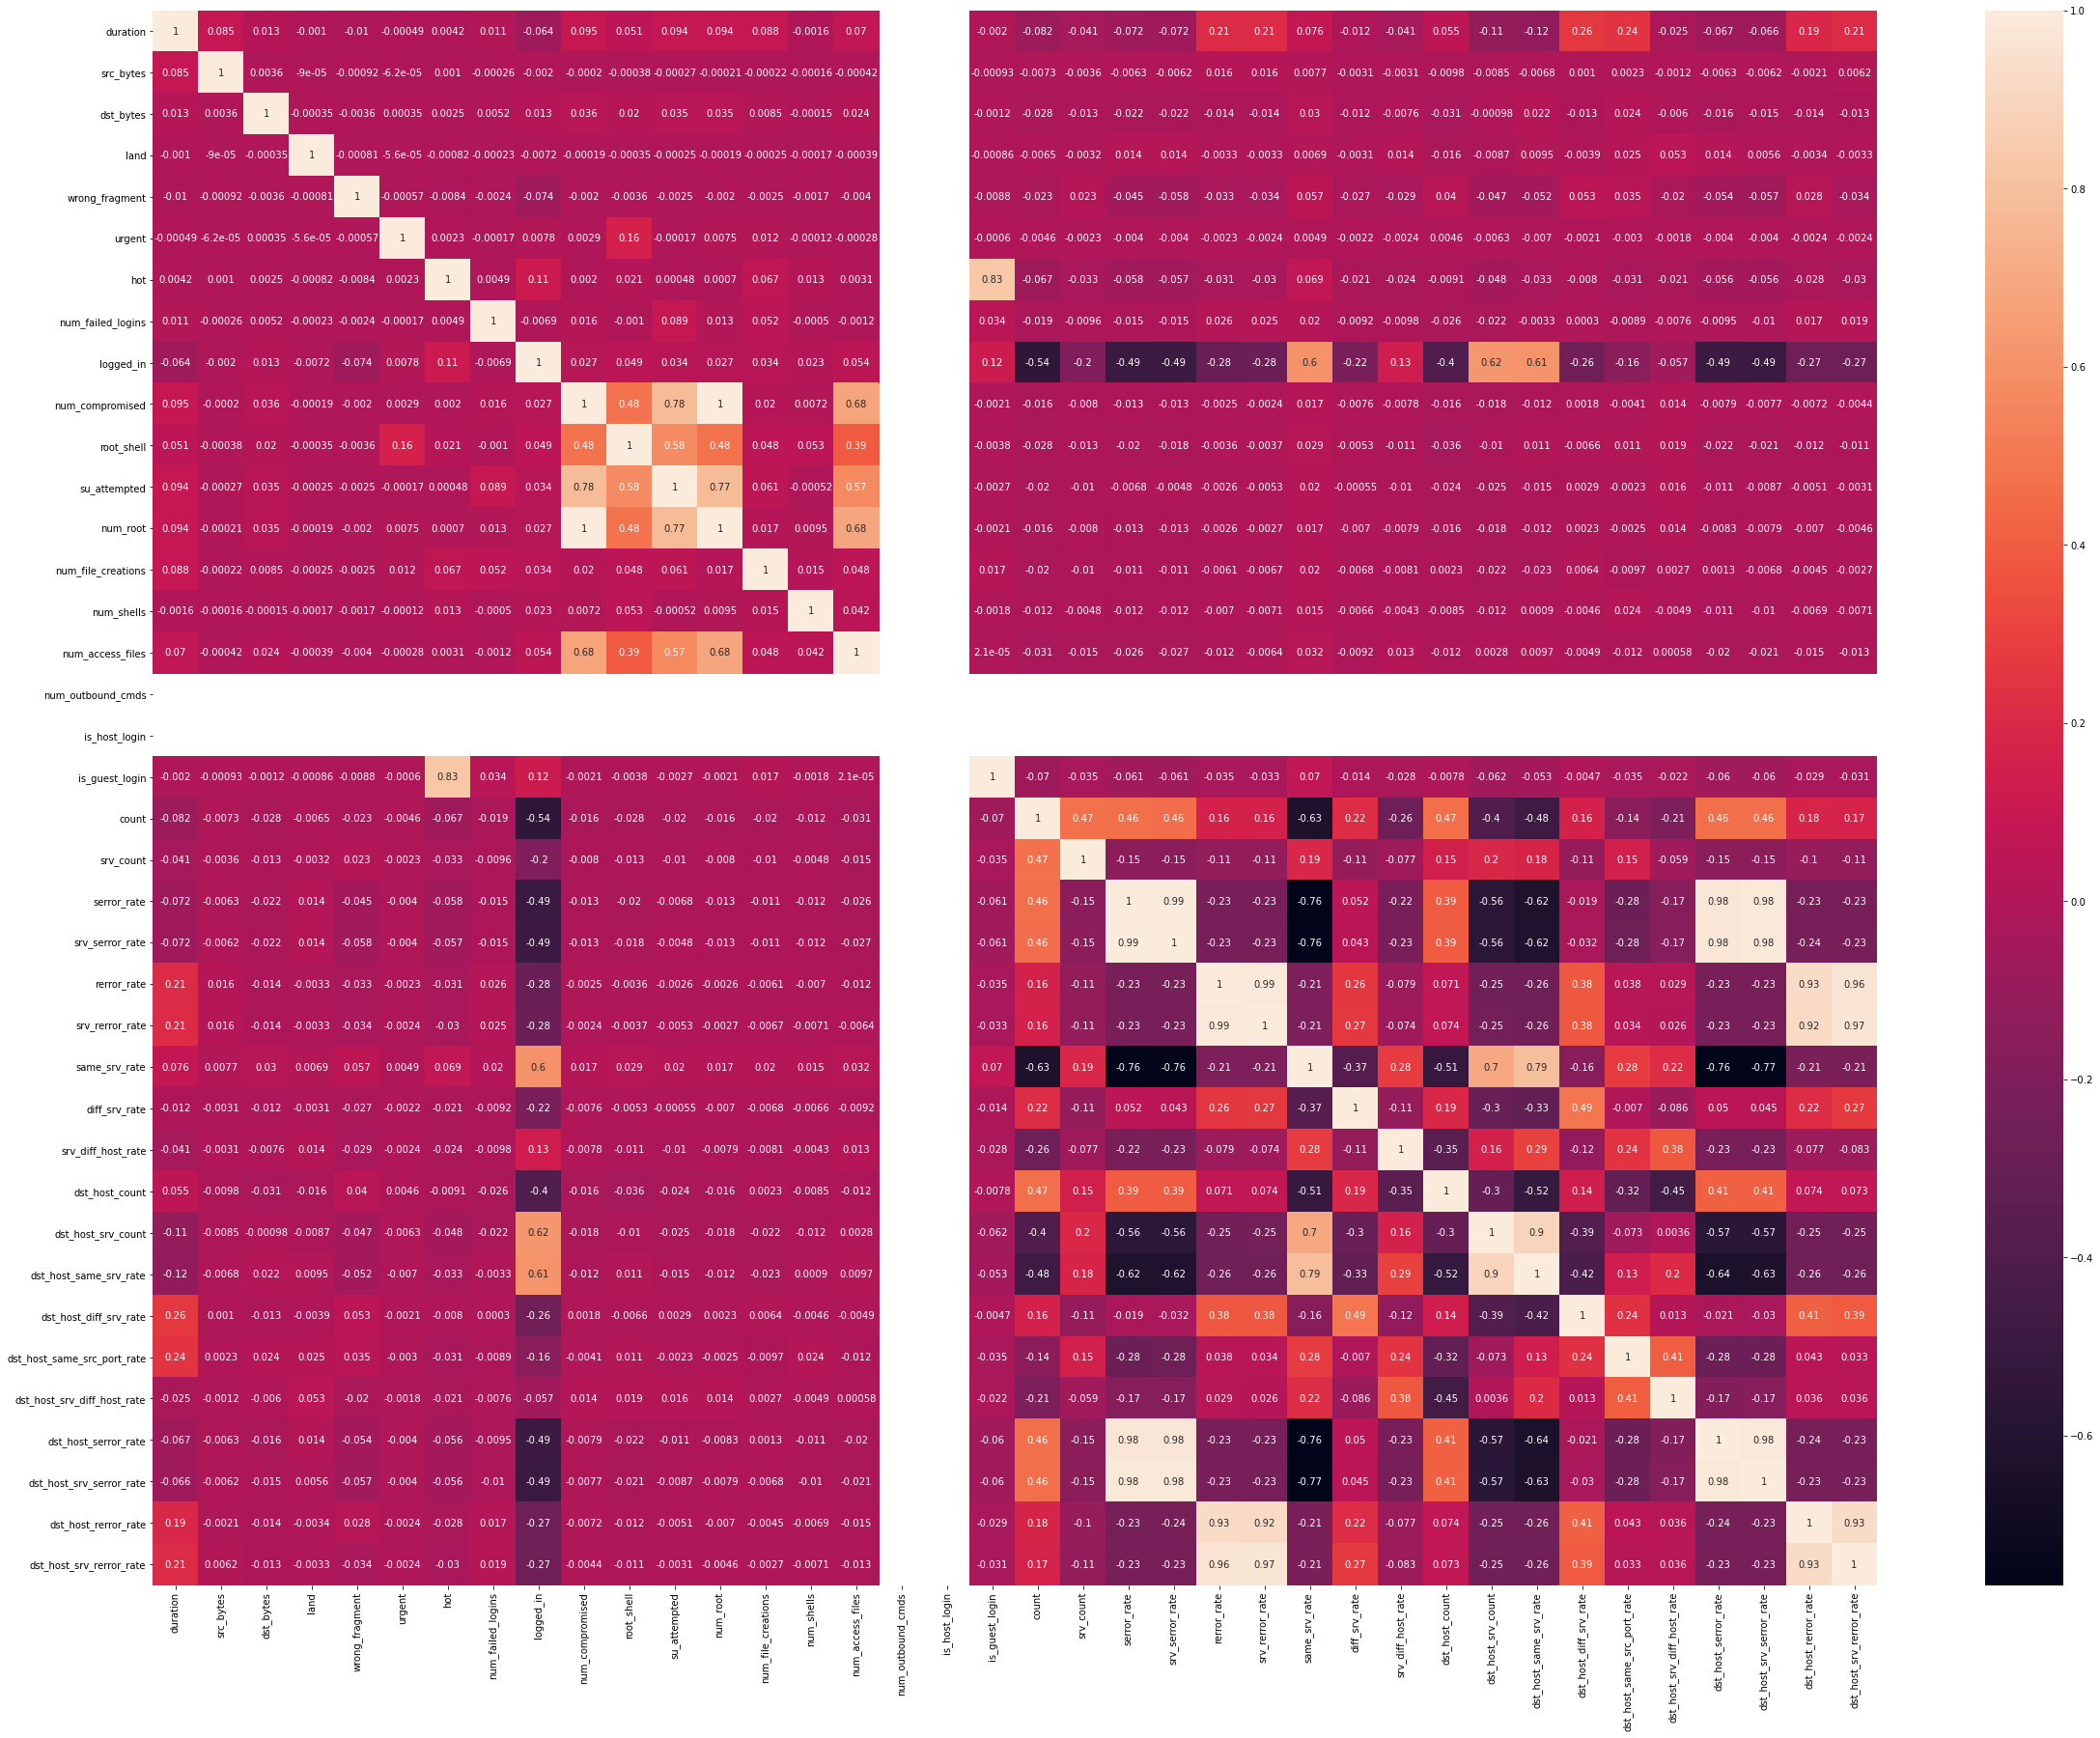

In [25]:
plt.figure(figsize=(40,30))
sns.heatmap(train.corr(), annot=True)

# import plotly.express as px
# fig = px.imshow(df.corr(), text_auto=True, aspect="auto")
# fig.show()

<AxesSubplot:xlabel='class', ylabel='count'>

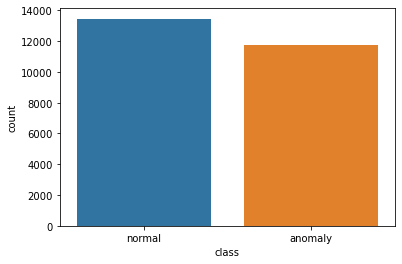

In [29]:
sns.countplot(x=train['class'])

# Label Encoding

List of Categorical columns requiring encoding and their values

In [3]:
# List of Categorical columns and their values
cat_cols = [col for col in train.columns if train[col].dtype == 'object']

for col in cat_cols:
    print(f"{col}\n{train[col].unique()}\n\n")

protocol_type
['tcp' 'udp' 'icmp']


service
['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001']


flag
['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']


class
['normal' 'anomaly']




In [4]:
def label_encode(df):
    encoders = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = {val:i for (i,val) in enumerate(df[col].unique())}
            encoders[col] = label_encoder
    
    return encoders

def get_encodings_for_column(encoding_dict: dict, col_name: str):
    return encoding_dict[col_name]

def get_encoding_labels_for_col(encoding_dict: dict, col_name: str):
    return list(encoding_dict[col_name].values())

def get_encoding_values_for_col(encoding_dict: dict, col_name: str):
    return list(encoding_dict[col_name].keys())

def get_encoding_value_for_label(encoding_dict: dict, col_name: str, label: int):
    return list(encoding_dict[col_name].keys())[label]

def get_encoding_label_for_value(encoding_dict: dict, col_name: str, value: str):
    return encoding_dict[col_name][value]

def get_reverse_encoding_dict(encoding_dict: dict):
    reverse_encoding = {
        col: {
            lbl:val for (val,lbl) in encodings_dict[col].items()
        } for col in encodings_dict
    }
    return reverse_encoding

In [5]:
encodings_dict = label_encode(train)
encodings_dict

{'protocol_type': {'tcp': 0, 'udp': 1, 'icmp': 2},
 'service': {'ftp_data': 0,
  'other': 1,
  'private': 2,
  'http': 3,
  'remote_job': 4,
  'name': 5,
  'netbios_ns': 6,
  'eco_i': 7,
  'mtp': 8,
  'telnet': 9,
  'finger': 10,
  'domain_u': 11,
  'supdup': 12,
  'uucp_path': 13,
  'Z39_50': 14,
  'smtp': 15,
  'csnet_ns': 16,
  'uucp': 17,
  'netbios_dgm': 18,
  'urp_i': 19,
  'auth': 20,
  'domain': 21,
  'ftp': 22,
  'bgp': 23,
  'ldap': 24,
  'ecr_i': 25,
  'gopher': 26,
  'vmnet': 27,
  'systat': 28,
  'http_443': 29,
  'efs': 30,
  'whois': 31,
  'imap4': 32,
  'iso_tsap': 33,
  'echo': 34,
  'klogin': 35,
  'link': 36,
  'sunrpc': 37,
  'login': 38,
  'kshell': 39,
  'sql_net': 40,
  'time': 41,
  'hostnames': 42,
  'exec': 43,
  'ntp_u': 44,
  'discard': 45,
  'nntp': 46,
  'courier': 47,
  'ctf': 48,
  'ssh': 49,
  'daytime': 50,
  'shell': 51,
  'netstat': 52,
  'pop_3': 53,
  'nnsp': 54,
  'IRC': 55,
  'pop_2': 56,
  'printer': 57,
  'tim_i': 58,
  'pm_dump': 59,
  'red_i'

In [54]:
# Before encoding
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [6]:
# Apply Encoding to train and test sets
train.replace(to_replace=encodings_dict, inplace=True)
test.replace(to_replace=encodings_dict, inplace=True)

In [91]:
# After encoding
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,0,0,0,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,1,1,0,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,0,2,1,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,0,3,0,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,0,3,0,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [92]:
# After encoding
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,2,2,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00
1,0,0,2,2,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00
2,2,0,0,0,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00
3,0,2,7,0,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00
4,1,0,9,5,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71


In [7]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,0,0,0,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,1,1,0,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,0,2,1,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,0,3,0,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,0,3,0,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [180]:
# Save the encoders_dict on disk
joblib.dump(encodings_dict, 'models/encodings_dict.joblib')

['models/encodings_dict.joblib']

# Feature selection

Using Feature Ranking with recursive feature Elimination (RFE approach).

In [8]:
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

In [9]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

# feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
# selected_features = [v for i, v in feature_map if i==True]
selected_features = X_train.columns[rfe.get_support()]

selected_features

Index(['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
       'logged_in', 'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count',
       'dst_host_same_srv_rate'],
      dtype='object')

In [209]:
# train['src_bytes']

In [11]:
X_train = X_train[selected_features]

In [12]:
X_train.head()

,protocol_type,service,flag,src_bytes,dst_bytes,logged_in,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_same_srv_rate
0,0,0,0,491,0,0,1.00,0.00,25,0.17
1,1,1,0,146,0,0,0.08,0.15,1,0.00
2,0,2,1,0,0,0,0.05,0.07,26,0.10
3,0,3,0,232,8153,1,1.00,0.00,255,1.00
4,0,3,0,199,420,1,1.00,0.00,255,1.00


In [102]:
X_train.min()

protocol_type                  0.0
service                        0.0
flag                           0.0
src_bytes                      0.0
dst_bytes                      0.0
same_srv_rate                  0.0
diff_srv_rate                  0.0
dst_host_srv_count             0.0
dst_host_same_srv_rate         0.0
dst_host_same_src_port_rate    0.0
dtype: float64

In [103]:
X_train.max()

protocol_type                          2.0
service                               65.0
flag                                  10.0
src_bytes                      381709090.0
dst_bytes                        5151385.0
same_srv_rate                          1.0
diff_srv_rate                          1.0
dst_host_srv_count                   255.0
dst_host_same_srv_rate                 1.0
dst_host_same_src_port_rate            1.0
dtype: float64

In [105]:
# Show unique value to confirm encoding

def show_unique_values(df):
    for col in df.columns:
        print(f"{col}:\n{df[col].unique()}\n\n")

show_unique_values(X_train)

protocol_type:
[0 1 2]


service:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]


flag:
[ 0  1  2  3  4  5  6  7  8  9 10]


src_bytes:
[ 491  146    0 ... 1466 2499 2896]


dst_bytes:
[   0 8153  420 ... 6160   99 2257]


same_srv_rate:
[1.   0.08 0.05 0.16 0.14 0.09 0.06 0.02 0.   0.17 0.1  0.01 0.03 0.28
 0.5  0.22 0.07 0.37 0.12 0.11 0.67 0.04 0.99 0.15 0.25 0.33 0.31 0.19
 0.27 0.97 0.43 0.18 0.24 0.4  0.13 0.46 0.23 0.42 0.44 0.21 0.2  0.35
 0.52 0.56 0.6  0.79 0.96 0.32 0.39 0.88 0.3  0.26 0.9  0.48 0.63 0.57
 0.75 0.36 0.98 0.51 0.87 0.93 0.62 0.45 0.73 0.34 0.92 0.8  0.83 0.89
 0.61 0.55 0.38 0.85 0.29 0.95 0.53 0.41 0.7  0.86 0.69 0.49 0.72 0.47
 0.74 0.64 0.77 0.65 0.58 0.54 0.59 0.71 0.78 0.91 0.94 0.82 0.81]


diff_srv_rate:
[0.   0.15 0.07 0.06 0.05 1.   0.08 0.5  0.1  0.67 0.02 0.31 0.01 0.11
 0.95 0.09 0.14 0.52 0.22

In [115]:
Y_train.head()

0    0
1    0
2    1
3    0
4    0
Name: class, dtype: int64

## Scale data

In [13]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)

In [181]:
joblib.dump(scale,filename='models/scaler.joblib')

['models/scaler.joblib']

## Data Segmentation/Splitting

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

In [15]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (17634, 10)
y_train shape: (17634,)
x_test shape: (7558, 10)
y_test shape: (7558,)


In [17]:
x_train[:5]

array([[-0.44400924, -0.63650425,  0.37067894, -0.01009252, -0.03930979,
        -0.80762582, -1.36605952, -0.12525061, -0.87725012, -0.86825665],
       [-0.44400924, -0.01506001,  0.37067894, -0.01009252, -0.03930979,
        -0.80762582, -0.88838365, -0.06924277, -0.51573243, -0.64550726],
       [-0.44400924,  0.45102317,  1.35013603, -0.01009252, -0.03930979,
        -0.80762582, -1.32056658, -0.01323494, -0.86821217, -1.00190629],
       [ 1.32556532, -0.71418478, -0.60877815, -0.01009211, -0.03930979,
        -0.80762582, -1.36605952,  0.26680423, -1.01281925, -1.13555592],
       [-0.44400924, -0.55882372, -0.60877815, -0.00997264, -0.03262278,
         1.23819717,  0.77210866, -0.34928194,  1.26474221,  1.06966306]])

In [213]:
Y_train.head()

0    0
1    0
2    1
3    0
4    0
Name: class, dtype: int64

# K Nearest Neighbors (KNN) classification model

In [121]:
def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [130]:
study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(objective, n_trials=20)
print(study_KNN.best_trial)

FrozenTrial(number=6, state=TrialState.COMPLETE, values=[0.9846520243450648], datetime_start=datetime.datetime(2025, 6, 23, 16, 9, 17, 370164), datetime_complete=datetime.datetime(2025, 6, 23, 16, 9, 18, 161139), params={'KNN_n_neighbors': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=6, value=None)


In [131]:
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)

KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

print(f"Train Score: {KNN_train}")
print(f"Test Score: {KNN_test}")

Train Score: 0.9934785074288307
Test Score: 0.9846520243450648


In [182]:
joblib.dump(KNN_model,"models/KNN_model.pkl")

['models/KNN_model.pkl']

# Decision Tree Classifier

In [132]:
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [133]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

FrozenTrial(number=11, state=TrialState.COMPLETE, values=[0.9961630060862662], datetime_start=datetime.datetime(2025, 6, 23, 16, 9, 44, 826682), datetime_complete=datetime.datetime(2025, 6, 23, 16, 9, 44, 921253), params={'dt_max_depth': 14, 'dt_max_features': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=11, value=None)


In [134]:
dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")

Train Score: 0.9998298741068391
Test Score: 0.9961630060862662


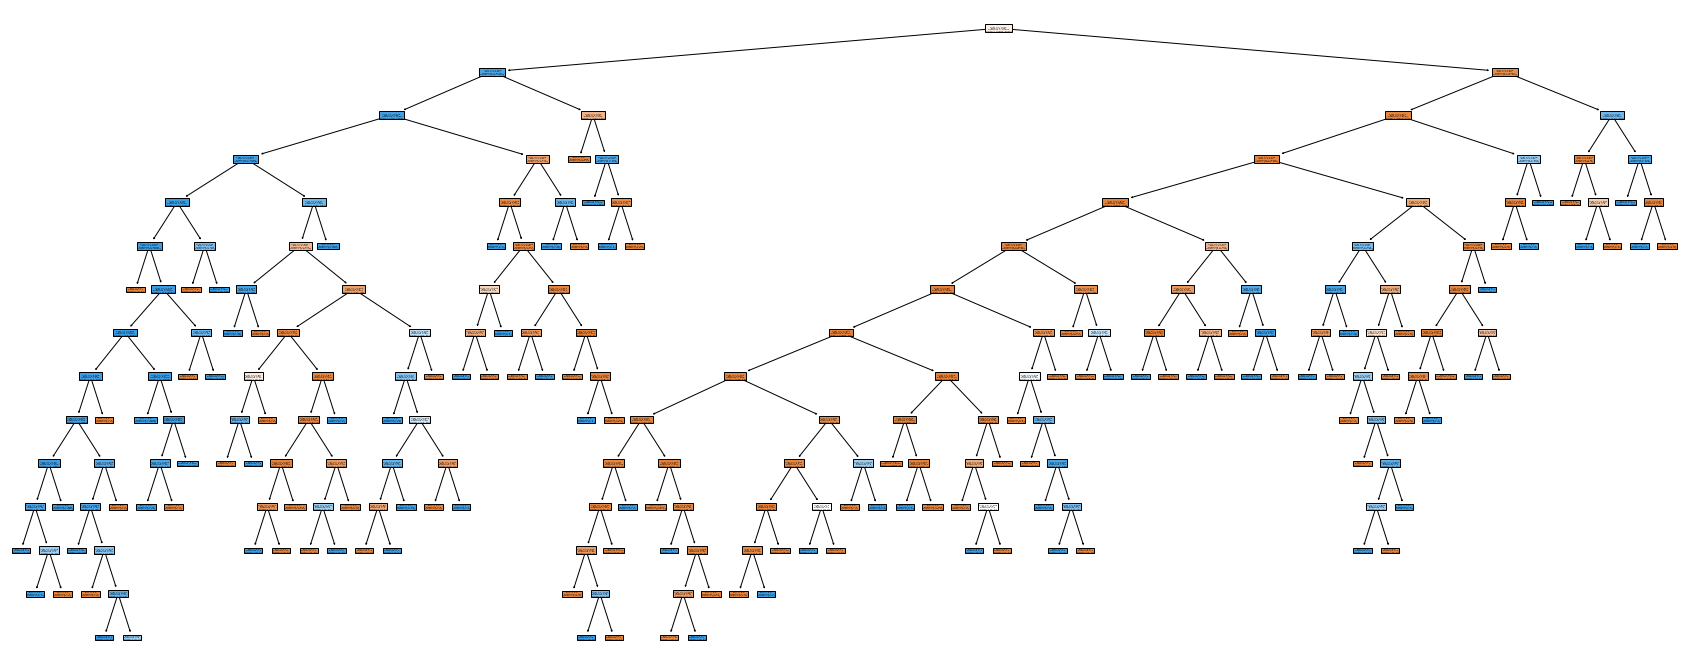

In [137]:
fig = plt.figure(figsize = (30,12))
tree.plot_tree(dt, filled=True);
plt.show()

In [138]:
dt.feature_importances_

array([0.02374576, 0.08394533, 0.00429108, 0.77303311, 0.03190866,
       0.00482588, 0.00091602, 0.04924017, 0.01926755, 0.00882643])

In [145]:
feature_importance = pd.DataFrame(
    data=dt.feature_importances_, index=selected_features, columns=["feature_importance"]
).sort_values(by="feature_importance", ascending=False)

feature_importance

,feature_importance
src_bytes,0.773033
service,0.083945
dst_host_srv_count,0.049240
dst_bytes,0.031909
protocol_type,0.023746
dst_host_same_srv_rate,0.019268
dst_host_same_src_port_rate,0.008826
same_srv_rate,0.004826
flag,0.004291
diff_srv_rate,0.000916


Text(0.5, 1.0, 'Feature Importances for Decision Tree\n')

<Figure size 720x576 with 0 Axes>

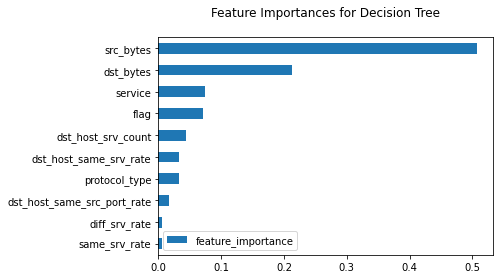

In [186]:
plt.figure(figsize=(10,8))
feature_importance.sort_values(by="feature_importance").plot.barh()
plt.title("Feature Importances for Decision Tree\n")

In [179]:
joblib.dump(dt,"models/Decision_Tree_model.pkl")

['Decision_Tree_model.pkl']

# Random Forest Classifier

Used Optuna for Parameter-tuning, The objective was to maximize the `accuracy` of the RandomForest Classifier model on the training set. The study/experiment was set to be done for 30-trials, the parameter set that maximizes the objective function (accuracy in our case) was then used for the final training.

The list of paramters and their value range used for the optimization are as follows:
- 'estimator': ('')
- 'rf_max_depth': (min:2, max:32)
- 'rf_max_features': (min:2, max:10)
- 'rf_n_estimators': (min:3, max:20)

In [151]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=False)
    rf_max_features = trial.suggest_int('rf_max_features', 2, 10, log=False)
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 3, 20, log=False)
    classifier_obj = RandomForestClassifier(max_features = rf_max_features, max_depth = rf_max_depth, n_estimators = rf_n_estimators)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [152]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=30)
print(study_rf.best_trial)

FrozenTrial(number=14, state=TrialState.COMPLETE, values=[0.9966922466260916], datetime_start=datetime.datetime(2025, 6, 23, 16, 22, 21, 871274), datetime_complete=datetime.datetime(2025, 6, 23, 16, 22, 22, 303153), params={'rf_max_depth': 15, 'rf_max_features': 7, 'rf_n_estimators': 17}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'rf_max_features': IntDistribution(high=10, log=False, low=2, step=1), 'rf_n_estimators': IntDistribution(high=20, log=False, low=3, step=1)}, trial_id=14, value=None)


In [153]:
rf = RandomForestClassifier(max_features = study_rf.best_trial.params['rf_max_features'], max_depth = study_rf.best_trial.params['rf_max_depth'], n_estimators = study_rf.best_trial.params['rf_n_estimators'])
rf.fit(x_train, y_train)

rf_train, rf_test = rf.score(x_train, y_train), rf.score(x_test, y_test)

print(f"Train Score: {rf_train}")
print(f"Test Score: {rf_test}")

Train Score: 0.9998865827378927
Test Score: 0.9961630060862662


In [155]:
feature_importance = pd.DataFrame(
    data=rf.feature_importances_, index=selected_features, columns=["feature_importance"]
).sort_values(by="feature_importance", ascending=False)

feature_importance

,feature_importance
src_bytes,0.507846
dst_bytes,0.212300
service,0.073774
flag,0.070168
dst_host_srv_count,0.044578
dst_host_same_srv_rate,0.032362
protocol_type,0.032206
dst_host_same_src_port_rate,0.016195
diff_srv_rate,0.005655
same_srv_rate,0.004917


Text(0.5, 1.0, 'Feature Importances for Random Forest\n')

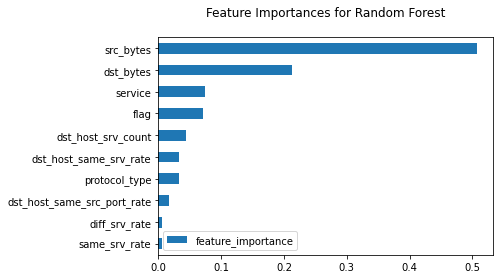

In [156]:
feature_importance.sort_values(by="feature_importance").plot.barh()
plt.title("Feature Importances for Random Forest\n")

In [187]:
joblib.dump(rf,"models/Random_Forest_model.pkl")

['models/Random_Forest_model.pkl']

# SVM Model

In [158]:
def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'linearSVC'])
    c = trial.suggest_float('c', 0.02, 1.0, step=0.02)
    if kernel in ['linear', 'rbf']:
        classifier_obj = SVC(kernel=kernel, C=c).fit(x_train, y_train)
    elif kernel == 'linearSVC':
        classifier_obj = LinearSVC(C=c).fit(x_train, y_train)
    elif kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 10)
        classifier_obj = SVC(kernel=kernel, C=c, degree=degree).fit(x_train, y_train)
        
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [159]:
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective, n_trials=30)
print(study_svm.best_trial)

FrozenTrial(number=24, state=TrialState.COMPLETE, values=[0.9741995236835141], datetime_start=datetime.datetime(2025, 6, 23, 17, 9, 49, 969826), datetime_complete=datetime.datetime(2025, 6, 23, 17, 9, 52, 706852), params={'kernel': 'rbf', 'c': 1.0}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'rbf', 'poly', 'linearSVC')), 'c': FloatDistribution(high=1.0, log=False, low=0.02, step=0.02)}, trial_id=24, value=None)


In [160]:
if study_svm.best_trial.params['kernel'] in ['linear', 'rbf']:
    SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'])
elif kernel == 'linearSVC':
    SVM_model = LinearSVC(C=study_svm.best_trial.params['c'])
elif kernel == 'poly':
    SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'], degree=study_svm.best_trial.params['degree'])

SVM_model.fit(x_train, y_train)

SVC()

In [161]:
SVM_train, SVM_test = SVM_model.score(x_train , y_train), SVM_model.score(x_test , y_test)

print(f"Training Score: {SVM_train}")
print(f"Test Score: {SVM_test}")

Training Score: 0.973857321084269
Test Score: 0.9741995236835141


In [188]:
joblib.dump(SVM_model,"models/SVM_model.pkl")

['models/SVM_model.pkl']

# Performance Evaluations

In [164]:
rf_predictions = rf.predict(x_test)
dt_predictions = dt.predict(x_test)
knn_predictions = KNN_model.predict(x_test)
svm_predictions = SVM_model.predict(x_test)

In [176]:
models = ["Random Forest", "KNN", "SVM"]

train_accuracies = [rf_train, KNN_train, SVM_train]

test_accuracies = [rf_test, KNN_test, SVM_test]

test_precisions = [
    precision_score(y_test, rf_predictions),
    precision_score(y_test, knn_predictions),
    precision_score(y_test, svm_predictions),
]

test_recalls = [
    recall_score(y_test, rf_predictions),
    recall_score(y_test, knn_predictions),
    recall_score(y_test, svm_predictions),
]

test_f1_scores = [
    f1_score(y_test, rf_predictions),
    f1_score(y_test, knn_predictions),
    f1_score(y_test, svm_predictions),
]

results_data = {
    "Model": models,
#     "Train Accuracy": train_accuracies,
    "Accuracy": test_accuracies,
    "Precision": test_precisions,
    "Recall": test_recalls,
    "F1-Score": test_f1_scores
}

results_df = pd.DataFrame(results_data)

results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.996163,0.995147,0.996569,0.995858
1,KNN,0.984652,0.991570,0.975129,0.983280
2,SVM,0.974200,0.979112,0.964837,0.971922


# Summary

In [177]:
data = [
    ["Random Forest", rf_train, rf_test], 
    ["Decision Tree", dt_train, dt_test], 
    ["KNN", KNN_train, KNN_test], 
    ["SVM", SVM_train, SVM_test]
]

col_names = ["Model", "Train Score", "Test Score",]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════╤═══════════════╤══════════════╕
│ Model         │   Train Score │   Test Score │
╞═══════════════╪═══════════════╪══════════════╡
│ Random Forest │      0.999887 │     0.996163 │
├───────────────┼───────────────┼──────────────┤
│ Decision Tree │      0.99983  │     0.996163 │
├───────────────┼───────────────┼──────────────┤
│ KNN           │      0.993479 │     0.984652 │
├───────────────┼───────────────┼──────────────┤
│ SVM           │      0.973857 │     0.9742   │
╘═══════════════╧═══════════════╧══════════════╛


In [178]:
print(tabulate(results_df.values, headers=results_df.columns, tablefmt="fancy_grid"))

╒═══════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Model         │   Accuracy │   Precision │   Recall │   F1-Score │
╞═══════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Random Forest │   0.996163 │    0.995147 │ 0.996569 │   0.995858 │
├───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ KNN           │   0.984652 │    0.99157  │ 0.975129 │   0.98328  │
├───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ SVM           │   0.9742   │    0.979112 │ 0.964837 │   0.971922 │
╘═══════════════╧════════════╧═════════════╧══════════╧════════════╛


In [192]:
# Save results
train_test_results_df = pd.DataFrame(data, columns=col_names)
train_test_results_df.to_csv("results/train_test_results_df.csv")
results_df.to_csv("results/results_all_metrics.csv")

In [193]:
# Loading and using a trained model for sample inference
model = joblib.load("models/Decision_Tree_model.pkl")
model.predict(x_test)

In [195]:
model.predict(x_test)

array([1, 1, 1, ..., 0, 0, 0])